In [1]:
import os 
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [2]:

from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle
import matplotlib

In [3]:
mode = "frequencies"

In [8]:
def load_liks(itraj, mode="damping", dtt=1e-6, total_time_in=6.):
    pars = give_def_params_discrimination(flip=0, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l1  = logliks[:,0] - logliks[:,1]
    
    pars = give_def_params_discrimination(flip=1, mode = mode)
    params, exp_path = check_params_discrimination(pars)
    [gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params
    logliks =load_data_discrimination_liks(itraj=itraj, total_time = total_time_in, dt=dtt, exp_path = exp_path)
    l0  = logliks[:,1] - logliks[:,0]
      
    return l0, l1

In [21]:
dtt = 1e-6
T = 200.#
ppp=5*1e3

In [27]:
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, total_time=T, ppp=ppp)

times = np.arange(0, total_time+ dt, dt)


indis = np.logspace(1,np.log10(len(times)-1), 50)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]


boundsB= np.arange(0,8,1.)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



n=1
ers = []
for itraj in tqdm(range(1,1000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode,dtt=dt ,total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
        pass
l0/=n#(Ntraj - len(ers))
l1/=n#(Ntraj - len(ers))


100%|██████████| 999/999 [01:02<00:00, 16.04it/s]


In [24]:
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

total_time, dt = get_total_time_dt(params, total_time=T, ppp=ppp)

times = np.arange(0, total_time+ dt, dt)


indis = np.logspace(1,np.log10(len(times)-1), 50)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]


boundsB= np.arange(0,8,1.)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}



n=1
ers = []
for itraj in tqdm(range(1,10000)):
    try:
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, mode=mode,dtt=dt ,total_time_in=total_time)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b


                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0

                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
        pass
l0/=n#(Ntraj - len(ers))
l1/=n#(Ntraj - len(ers))


  4%|▍         | 434/9999 [00:29<10:45, 14.81it/s]


KeyboardInterrupt: 

In [28]:
len(ers)

0

In [31]:
bpos = boundsB[boundsB >=0]
bneg = boundsB[boundsB <0]

stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())

for k,val in enumerate(values1):
    if len(val)>2:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


In [32]:
                
cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(boundsB[int(len(boundsB)/2):]):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms1]
    anals1.append(gp1)
    
    gp0 = [prob(t, b, kappa1, kappa0, eta1 , eta0, n1, n0, gamma1, gamma0)[0] for t in timms0]
    anals0.append(gp0)
    

<ipython-input-32-dd155c07152b>:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
<ipython-input-32-dd155c07152b>:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)


In [37]:
### stationary state for the covariance
def stat(gamma, omega, n, eta, kappa):
    suc = n + 0.5 + kappa/gamma
    sst = (gamma/(8*eta*kappa))*(np.sqrt(1 + 16*eta*kappa*suc/gamma ) -1 )
    return suc, sst

sigma,_ = stat(gamma1, omega1, n1, eta1, kappa1)

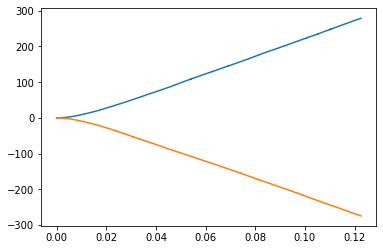

In [63]:
plt.plot(times,l1[:-1])
plt.plot(times,l0[:-1])

In [64]:

alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

std_times = np.sqrt(std_times1**2   + std_times0**2)#0.5*(np.array(avg_times0) + np.array(avg_times1) )
stoch = avg_times
stoch_std = std_times


avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

<ipython-input-64-7160984af770>:10: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
/home/giq/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid valu

In [65]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
b_to_ep = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

<ipython-input-65-b712e0ad23ba>:1: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


In [76]:
bb = np.linspace(0,1000,1000)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(bb):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

<ipython-input-65-b712e0ad23ba>:2: RuntimeWarning: overflow encountered in exp
  b_to_ep = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
<ipython-input-65-b712e0ad23ba>:2: RuntimeWarning: invalid value encountered in true_divide
  b_to_ep = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))


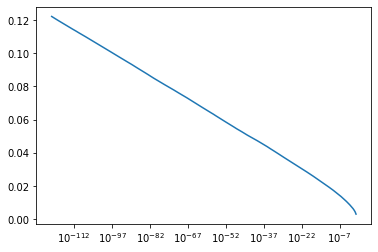

In [77]:
ax=plt.subplot(111)
ax.plot(b_to_ep(bb),stop_avg_1)
ax.set_xscale("log")

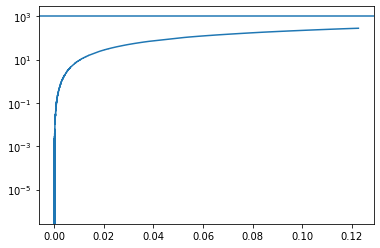

In [68]:
ax=plt.subplot(111)
ax.plot(times,l1[:-1])
for k in bb[:-2:-1]:
    ax.axhline(k)
ax.set_yscale("log")

In [69]:
bb = np.linspace(0,1000,100)
stop_avg_1, stop_avg_0 = [], []
for indb,b in enumerate(boundsB):
    if b>=0:
        stop_avg_1.append(get_stop_time(l1, b, times))
        stop_avg_0.append(get_stop_time(l0, b,times))

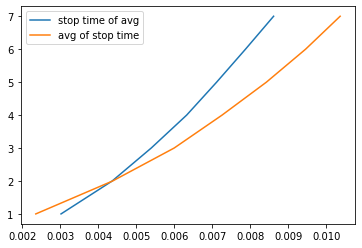

In [72]:
plt.plot(stop_avg_1, boundsB[boundsB>=0], label="stop time of avg")
plt.plot(stoch, boundsB[boundsB>=0], label="avg of stop time")
plt.legend()

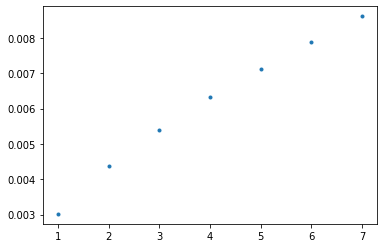

In [74]:
plt.plot(boundsB[boundsB>=0], stop_avg_1,'.')

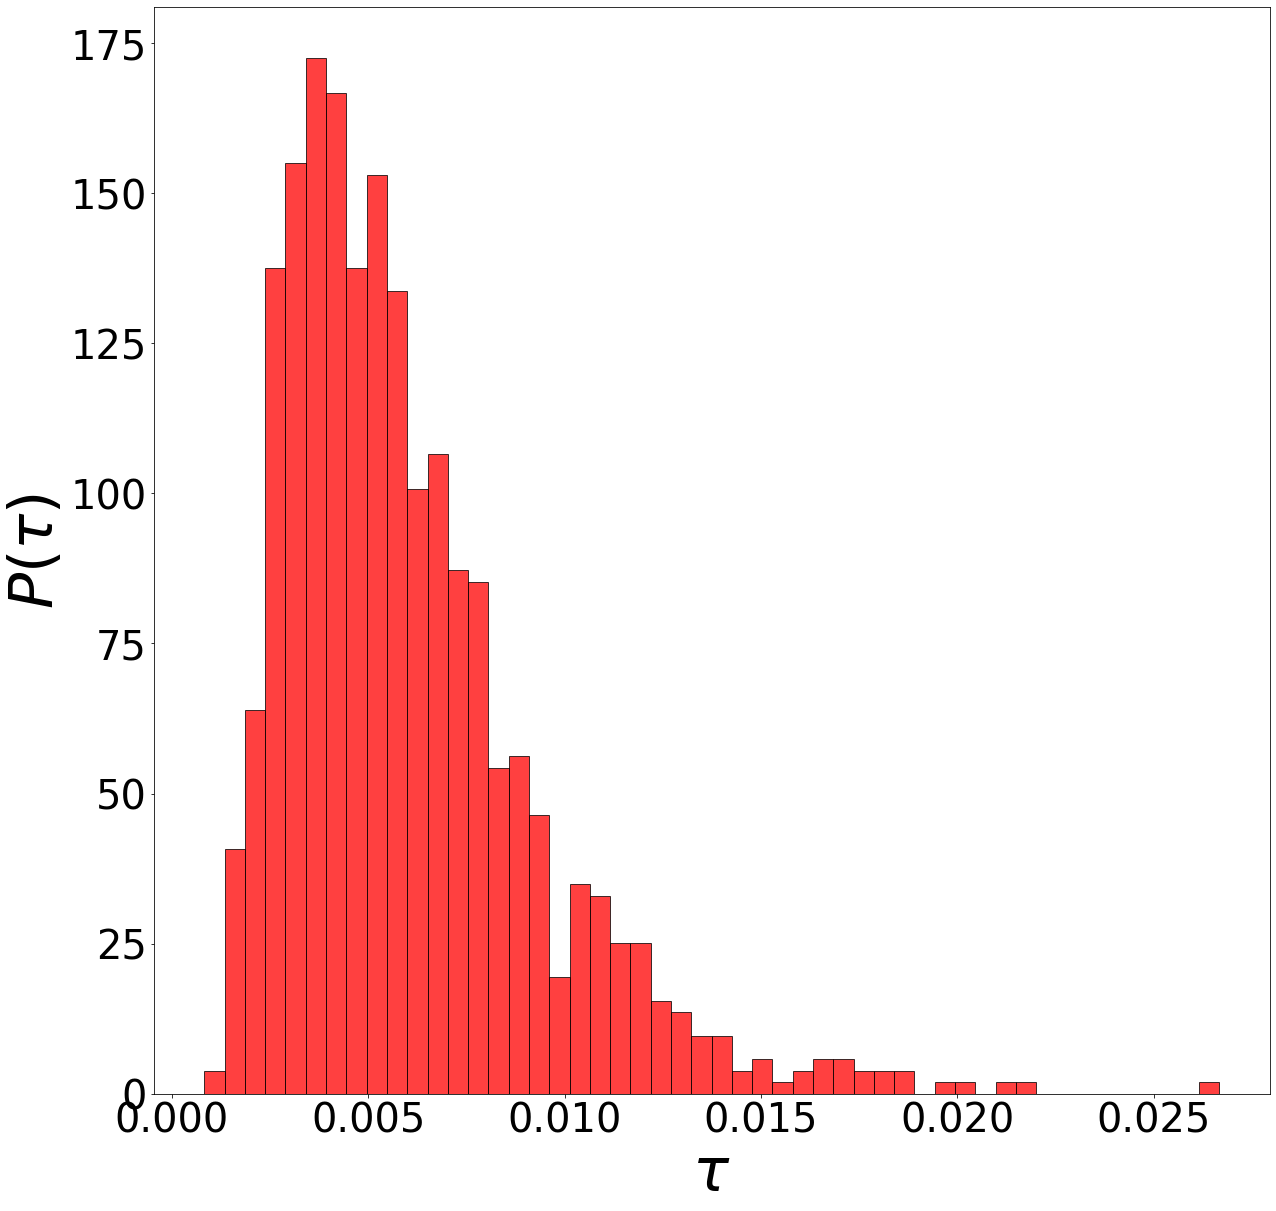

In [80]:
LS, TS = 60, 40
plt.figure(figsize=(20,20))
ax = plt.subplot(111)
indb = -1
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

In [81]:

alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)


bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]


stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

std_times = np.sqrt(std_times1**2   + std_times0**2)#0.5*(np.array(avg_times0) + np.array(avg_times1) )
stoch = avg_times
stoch_std = std_times

<ipython-input-81-6ecefa0eb6c9>:11: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
/home/giq/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/giq/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid valu

In [82]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

<ipython-input-82-e1703a25a0cb>:1: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


In [85]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]


<ipython-input-85-e1703a25a0cb>:1: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


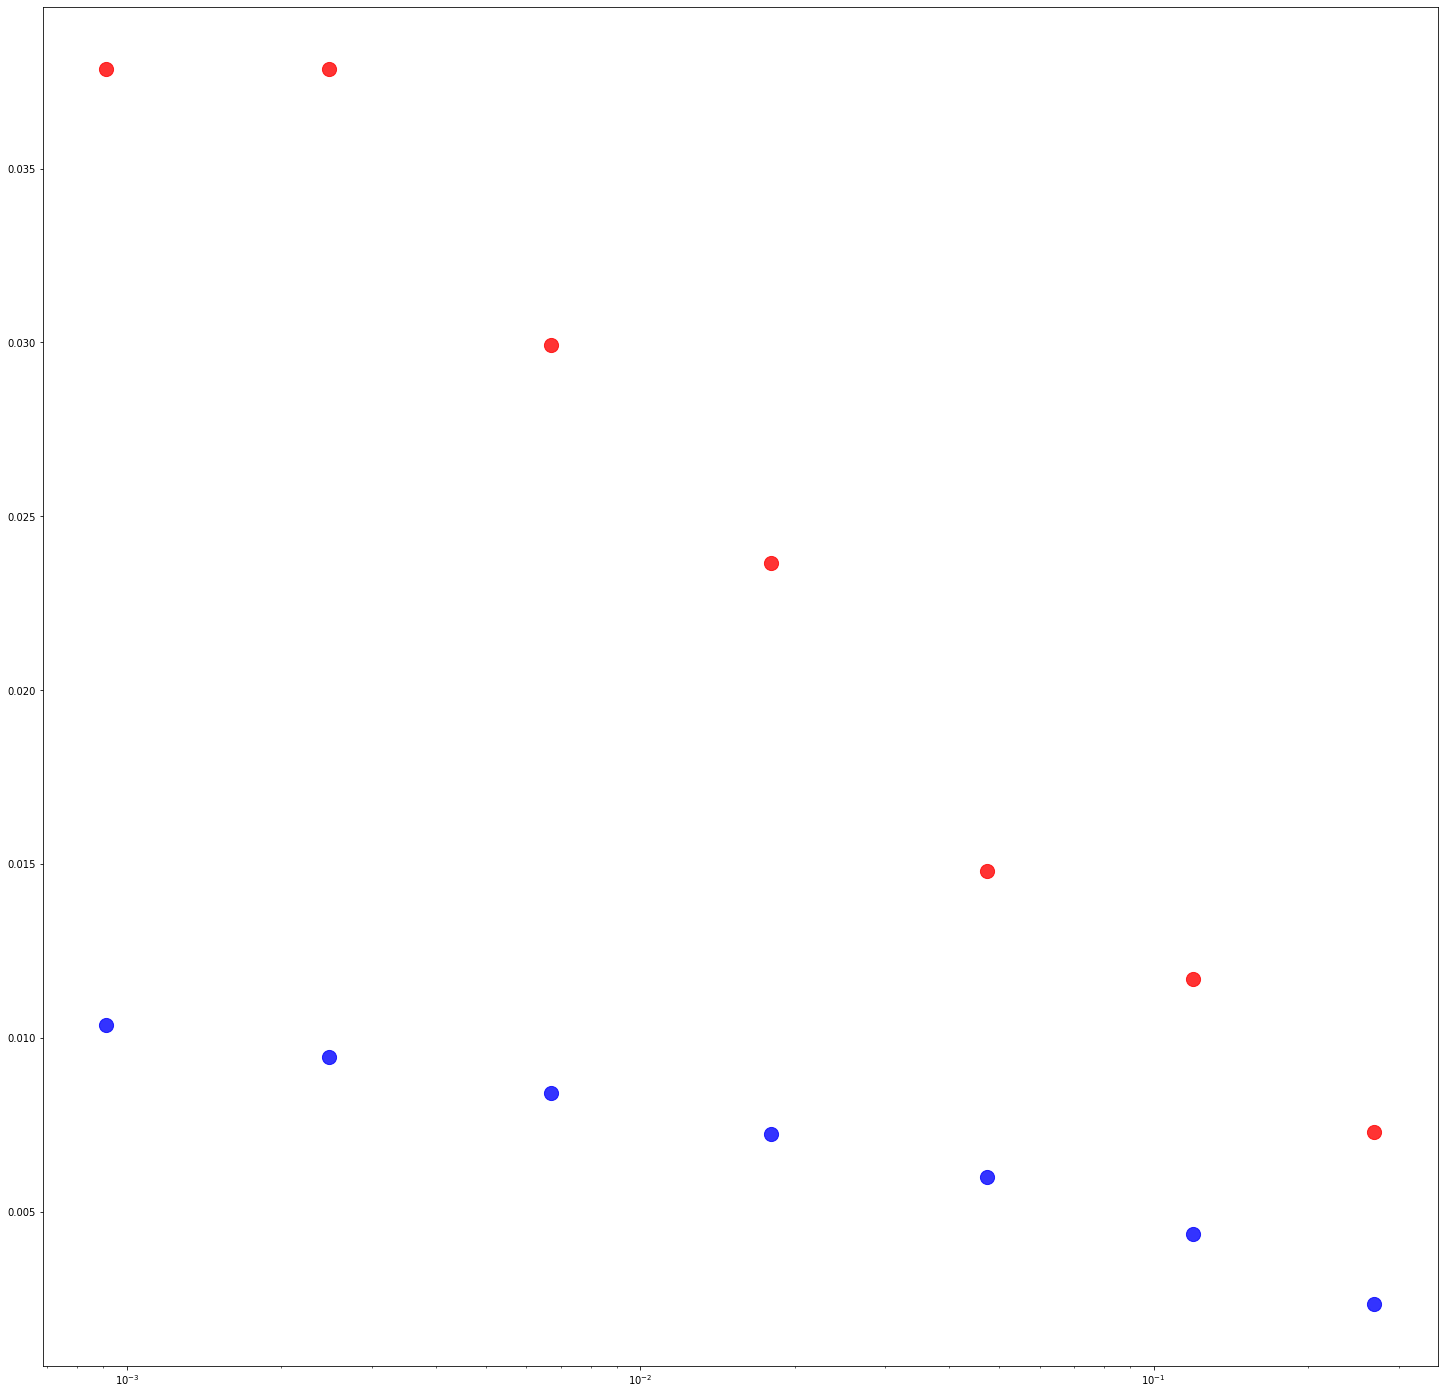

In [90]:

fig = plt.figure(figsize=(25,25))
ax = plt.subplot(111)
lw=10
ax.scatter(errs, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")
ax.set_xscale("log")


In [88]:

fig = plt.figure(figsize=(25,25))
ax = plt.subplot(111)
lw=10
ax.scatter(errs, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")
#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
#ax.set_xscale("log")
ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"damp_adaptive_vs_det.pdf")


ValueError: cannot convert float NaN to integer

<Figure size 1800x1800 with 1 Axes>